In [1]:
# Setting up the Colab environment. DO NOT EDIT!
import os
import warnings
warnings.filterwarnings("ignore")

try:
    import otter

except ImportError:
    ! pip install -q otter-grader==4.0.0
    import otter

if not os.path.exists('walkthrough-tests'):
    zip_files = [f for f in os.listdir() if f.endswith('.zip')]
    assert len(zip_files)>0, 'Could not find any zip files!'
    assert len(zip_files)==1, 'Found multiple zip files!'
    ! unzip {zip_files[0]}

grader = otter.Notebook(colab=True,
                        tests_dir = 'walkthrough-tests')

# Walkthrough

## Learning Objectives
At the end of this learning activity you will be able to:

* Practice summarize observations by sample using `groupby`.
* Measure the uncertainty of the estimate of the mean.
* Distinguish when to use parametric and non-parametric estimates of error.
* Practice merging two dataframes.

This week we will start looking at the imaging data we discussed with Dr. Gaskill.
In this experiment, they used pH responsive beads that flouresce when in the low pH environment of the phagasome.
With this technology, they exposed cells to different levels of dopamine and measured the uptake of these beads.
They did this using a _high content_ imager which automates the process of scanning a plate, detecting cell boundaries, and _spots_ of flourescing beads.

This imager returns a giant spreadsheet where each cell is a row and the columns are the cell area, bead count, and intensity.
This dataset of a single 96-well plate has over **315,000 cells** measured across 60 samples of 20 conditions performed in triplicate.

---------------------------------------------

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
cell_level_data = pd.read_csv('pHrodo_DMEM.csv')
cell_level_data.head()

,Well,Field,Cell_Number,Top,Left,XCentroid,YCentroid,ObjectAreaCh1,ObjectTotalIntenCh1,ObjectAvgIntenCh1,ObjectVarIntenCh1,SpotCountCh2,SpotTotalAreaCh2,SpotAvgAreaCh2,SpotTotalIntenCh2,SpotAvgIntenCh2,TotalIntenCh2,AvgIntenCh2
0,B2,1,1,127,634,703.418228,197.382766,14889,40514018,2721.070455,1428.303950,5,122,24.400000,113038,926.540984,1151084,77.311035
1,B2,1,2,203,53,119.211656,272.750579,14670,36697977,2501.566258,1270.956156,0,0,0.000000,0,0.000000,531102,36.203272
2,B2,1,3,477,595,664.088627,538.774772,14341,38322709,2672.248030,1543.100214,16,382,23.875000,823276,2155.172775,3011914,210.021198
3,B2,1,4,488,302,389.107857,581.589321,25302,59364634,2346.242748,939.256416,21,324,15.428571,259496,800.913580,1265323,50.008814
4,B2,1,5,713,717,808.196306,790.656465,22414,57729816,2575.614170,1724.895666,0,0,0.000000,0,0.000000,590502,26.345231


## Sumarize by sample

### Q1: How many cells are in each well?

In [4]:
# Use `groupby` to count the number of cells per well

cells_per_well = cell_level_data.groupby('Well')['Cell_Number'].count() # SOLUTION
cells_per_well.describe()

count     60.000000
mean     525.966667
std      133.318145
min      257.000000
25%      418.250000
50%      528.000000
75%      641.000000
max      794.000000
Name: Cell_Number, dtype: float64

In [ ]:
grader.check("q1_cells_per_well")

<Axes: >

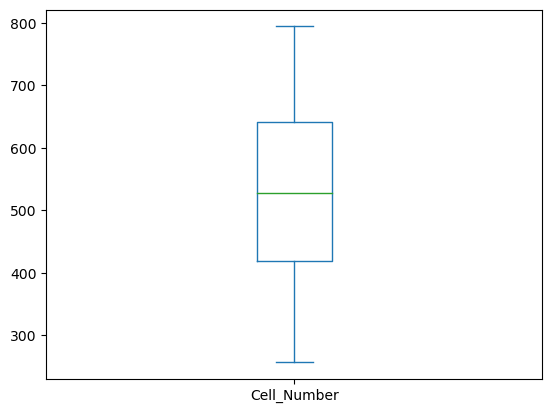

In [7]:
cells_per_well.plot(kind='box')

The count ranges from 257 to 794 with an average of 525 cells per well.

## Measuring phagocytosis

Each cell can take up 0 or more pH beads.
Our biological question is whether dopamine changes the amount of beads that are taken up by the cells.

<Axes: xlabel='SpotCountCh2', ylabel='Percent'>

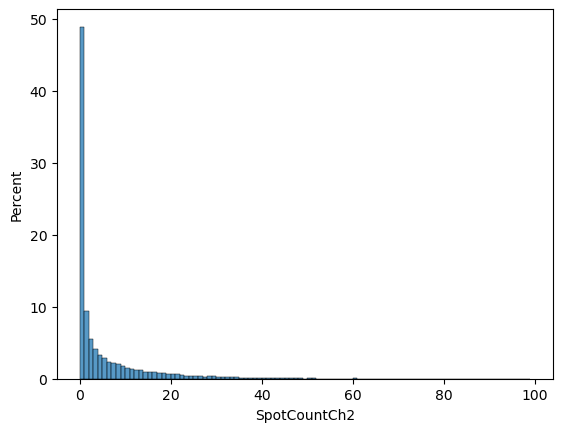

In [8]:
sns.histplot(data = cell_level_data,
             x = 'SpotCountCh2',
             bins = np.arange(0, 100),
             stat = 'percent')

From our graph, we can see that most cells took up 0 beads and then about 10% took up 1, ~5% took up two, etc.

We hypothesize that dopamine treatment will increase the average number of beads taken up by cells.

<Axes: xlabel='SpotCountCh2', ylabel='Well'>

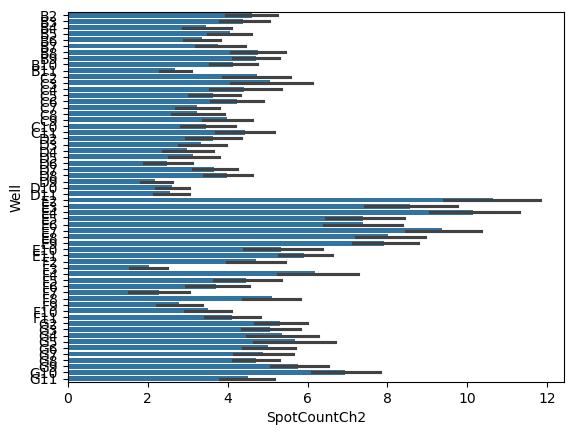

In [9]:
# Visually
sns.barplot(data = cell_level_data,
            y = 'Well',
            x = 'SpotCountCh2')

The length of the bars indicates the average number of spots per cell while the black hashes indicate the 95% CI of that estimate.

In [10]:
# Numerically
well_level_data = cell_level_data.groupby('Well')['SpotCountCh2'].agg(['mean', 'sem', 'count'])
well_level_data.head()

,mean,sem,count
Well,,,
B10,4.138889,0.290394,612
B11,2.692828,0.200705,739
B2,4.599343,0.326940,609
B3,4.391667,0.312008,720
B4,3.464491,0.301991,521


## Decoding samples

Up to now we've been treating all of our without knowing which treatment they came from.
Now that we've collapsed our data to a single representative number for each sample, we can merge with our plate map.

In [11]:
# Load in plate map
plate_map = pd.read_csv('plate_map.csv')

# Treat concentration as a category instead of a number
plate_map['pHrodo_conc_ug'] = pd.Categorical(plate_map['pHrodo_conc_ug'])

plate_map.head()

,well,pHrodo_conc_ug,DA_Tx,replicate
0,B2,5.0,veh,Rep1
1,C2,5.0,veh,Rep2
2,D2,5.0,veh,Rep3
3,B3,5.0,DA06,Rep1
4,C3,5.0,DA06,Rep2


This function helps visualize how the plate is layed out.

In [12]:
def fancy_pivot(df):
    import re
    # Extract row letters and column numbers from the 'well' column
    df['row'] = df['well'].apply(lambda x: re.match(r'([A-H])', x).group(1))
    df['col'] = df['well'].apply(lambda x: int(re.match(r'[A-H]([0-9]{1,2})', x).group(1)))

    # Concatenate all other columns as 'V1-V2-V3' format
    value_columns = [col for col in df.columns if col not in ['well', 'row', 'col']]
    df['values'] = df[value_columns].astype(str).agg('-'.join, axis=1)

    # Create pivot table with aggfunc as 'first'
    pivot_table = df.pivot_table(index='row', columns='col', values='values', aggfunc='first')

    return pivot_table


fancy_pivot(plate_map)

col,2,3,4,5,6,7,8,9,10,11
row,,,,,,,,,,
B,5.0-veh-Rep1,5.0-DA06-Rep1,5.0-DA07-Rep1,5.0-DA08-Rep1,5.0-DA09-Rep1,5.0-DA10-Rep1,5.0-DA11-Rep1,5.0-DA12-Rep1,5.0-DA13-Rep1,5.0-DA14-Rep1
C,5.0-veh-Rep2,5.0-DA06-Rep2,5.0-DA07-Rep2,5.0-DA08-Rep2,5.0-DA09-Rep2,5.0-DA10-Rep2,5.0-DA11-Rep2,5.0-DA12-Rep2,5.0-DA13-Rep2,5.0-DA14-Rep2
D,5.0-veh-Rep3,5.0-DA06-Rep3,5.0-DA07-Rep3,5.0-DA08-Rep3,5.0-DA09-Rep3,5.0-DA10-Rep3,5.0-DA11-Rep3,5.0-DA12-Rep3,5.0-DA13-Rep3,5.0-DA14-Rep3
E,7.5-veh-Rep1,7.5-DA06-Rep1,7.5-DA07-Rep1,7.5-DA08-Rep1,7.5-DA09-Rep1,7.5-DA10-Rep1,7.5-DA11-Rep1,7.5-DA12-Rep1,7.5-DA13-Rep1,7.5-DA14-Rep1
F,7.5-veh-Rep2,7.5-DA06-Rep2,7.5-DA07-Rep2,7.5-DA08-Rep2,7.5-DA09-Rep2,7.5-DA10-Rep2,7.5-DA11-Rep2,7.5-DA12-Rep2,7.5-DA13-Rep2,7.5-DA14-Rep2
G,7.5-veh-Rep3,7.5-DA06-Rep3,7.5-DA07-Rep3,7.5-DA08-Rep3,7.5-DA09-Rep3,7.5-DA10-Rep3,7.5-DA11-Rep3,7.5-DA12-Rep3,7.5-DA13-Rep3,7.5-DA14-Rep3


Merge the plate map with the well level aggregates.

In [13]:
sample_level_data = pd.merge(plate_map, well_level_data,
                             left_on = 'well', right_index = True)
sample_level_data.head()

,well,pHrodo_conc_ug,DA_Tx,replicate,row,col,values,mean,sem,count
0,B2,5.0,veh,Rep1,B,2,5.0-veh-Rep1,4.599343,0.326940,609
1,C2,5.0,veh,Rep2,C,2,5.0-veh-Rep2,4.737265,0.426620,373
2,D2,5.0,veh,Rep3,D,2,5.0-veh-Rep3,3.623116,0.350467,398
3,B3,5.0,DA06,Rep1,B,3,5.0-DA06-Rep1,4.391667,0.312008,720
4,C3,5.0,DA06,Rep2,C,3,5.0-DA06-Rep2,5.070039,0.538362,257


Now we can visualize the well level aggregates by the treatment condition.

Text(0, 0.5, 'mean(bead count)')

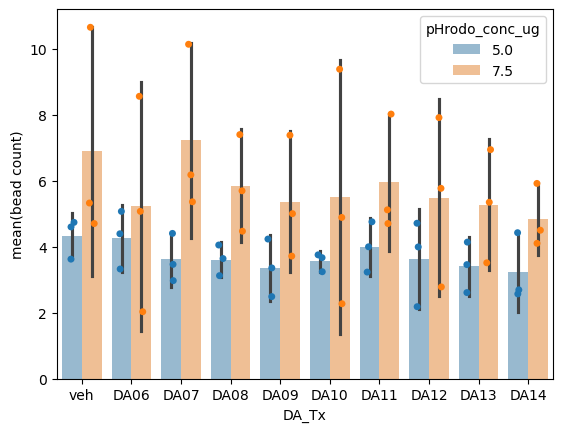

In [14]:
ax = sns.barplot(data = sample_level_data,
            hue = 'pHrodo_conc_ug',
            x = 'DA_Tx',
            y = 'mean', errorbar=('se', 2), alpha=0.5)

sns.stripplot(data = sample_level_data,
            hue = 'pHrodo_conc_ug',
            x = 'DA_Tx',
            y = 'mean', dodge=True, legend=False, ax=ax)

ax.set_ylabel('mean(bead count)')

### Q2: Describe the graph

_Points:_ 5

In [15]:
# Which experimental condition (pHrodo_conc_ug) had less noise in the measurement?
# Answer 5.0 or 7.5
q2a = 5.0 # SOLUTION


**q2a reasoning**: *your answer here*

In [16]:
# Does this graph show evidence that dopamine increases the amount of beads phagocytosed?
# Anwser 'yes' or 'no'
q2b = 'no' # SOLUTION


**q2b reasoning**: *your answer here*

In [ ]:
grader.check("q2_graph")

In the next few weeks well cover strategies to quantify our hypothesis using techniques like ANOVAs and multiple regression.

---------------------------------------------

## Submission

Check:
 - That all tables and graphs are rendered properly.
 - Code completes without errors by using `Restart & Run All`.
 - All checks **pass**.
 
Then save the notebook and the `File` -> `Download` -> `Download .ipynb`. Upload this file to BBLearn.